In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation
from datetime import datetime, timedelta

# ===============================
# PARÁMETROS
# ===============================
LS_ITERS = 50   # iteraciones mínimos cuadrados
MU = 0.5        # paso del gradiente

# ===============================
# MODELO SOLAR SIMPLIFICADO
# ===============================
def solar_position(date):
    hour = date.hour + date.minute / 60

    az = np.deg2rad(15 * (hour - 12) + 180)
    el = np.deg2rad(max(0, 60 - abs(hour - 12) * 7))

    return az, el

In [3]:
# ===============================
# MÍNIMOS CUADRADOS
# ===============================
def least_squares_roll_pitch(az, el):
    s = np.array([
        np.cos(el) * np.sin(az),
        np.cos(el) * np.cos(az),
        np.sin(el)
    ])

    phi, psi = 0.0, 0.0

    for _ in range(LS_ITERS):
        n = np.array([
            -np.sin(phi) * np.cos(psi),
            np.sin(psi),
            np.cos(phi) * np.cos(psi)
        ])

        e = n - s

        dJ_dphi = 2 * np.dot(e, [
            -np.cos(phi) * np.cos(psi),
            0,
            -np.sin(phi) * np.cos(psi)
        ])

        dJ_dpsi = 2 * np.dot(e, [
            np.sin(phi) * np.sin(psi),
            np.cos(psi),
            -np.cos(phi) * np.sin(psi)
        ])

        phi -= MU * dJ_dphi
        psi -= MU * dJ_dpsi

    return phi, psi

In [4]:
# ===============================
# SIMULACIÓN TEMPORAL
# ===============================
def simulate(date, duration_hours=10):
    t0 = datetime(date.year, date.month, date.day, 6, 0)
    times = [t0 + timedelta(minutes=5*i) for i in range(int(duration_hours*12))]

    az_hist, el_hist = [], []
    phi_hist, psi_hist = [], []

    for t in times:
        az, el = solar_position(t)
        if el <= 0:
            continue

        phi, psi = least_squares_roll_pitch(az, el)

        az_hist.append(az)
        el_hist.append(el)
        phi_hist.append(phi)
        psi_hist.append(psi)

    return az_hist, el_hist, phi_hist, psi_hist

In [5]:
# ===============================
# ENTRADA DEL USUARIO
# ===============================
fecha_str = input("Ingrese la fecha (YYYY-MM-DD): ")
duracion = float(input("Ingrese duración de simulación en horas: "))

fecha = datetime.strptime(fecha_str, "%Y-%m-%d")

az_hist, el_hist, phi_hist, psi_hist = simulate(fecha, duracion)

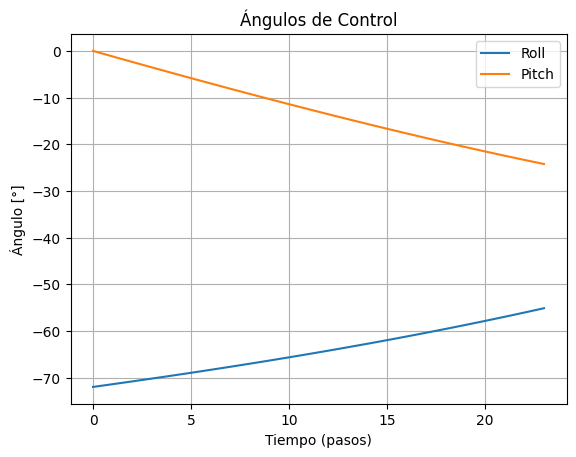

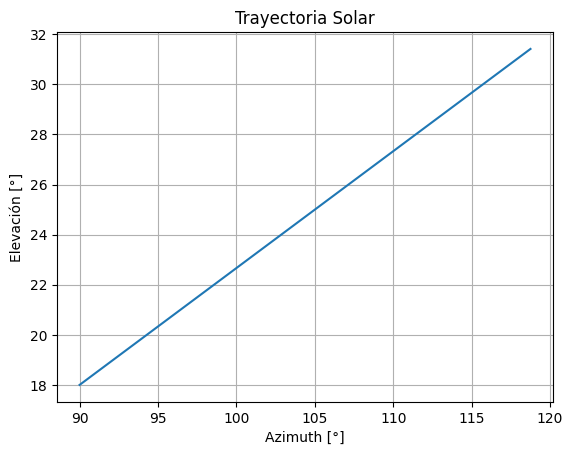

In [11]:
# ===============================
# GRÁFICAS 2D
# ===============================
time_axis = np.arange(len(phi_hist))

plt.figure()
plt.plot(time_axis, np.rad2deg(phi_hist), label="Roll")
plt.plot(time_axis, np.rad2deg(psi_hist), label="Pitch")
plt.xlabel("Tiempo (pasos)")
plt.ylabel("Ángulo [°]")
plt.title("Ángulos de Control")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(np.rad2deg(az_hist), np.rad2deg(el_hist))
plt.xlabel("Azimuth [°]")
plt.ylabel("Elevación [°]")
plt.title("Trayectoria Solar")
plt.grid()
plt.show()

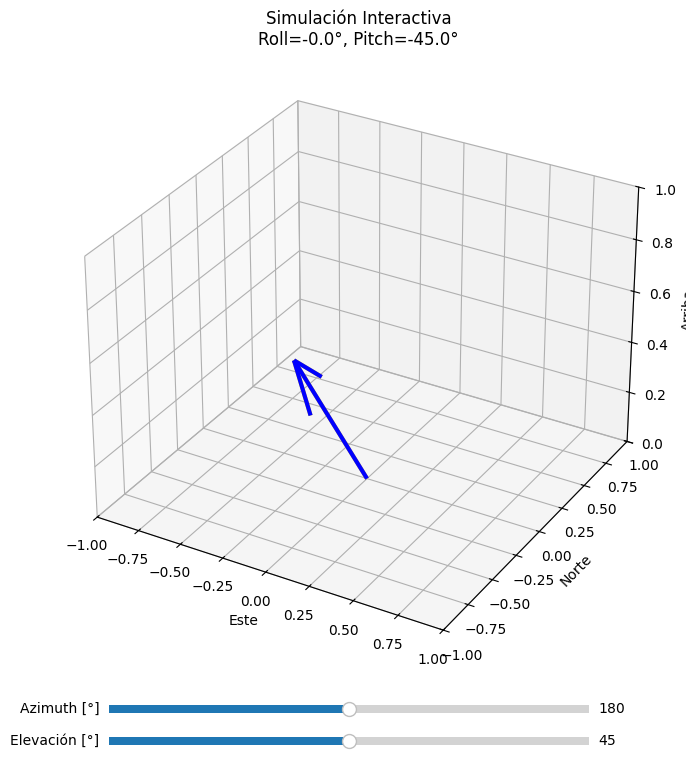

In [8]:
# ===============================
# SIMULACIÓN 3D INTERACTIVA
# ===============================
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([0,1])
ax.set_xlabel("Este")
ax.set_ylabel("Norte")
ax.set_zlabel("Arriba")

sun_vec = None
panel_vec = None

ax_az = plt.axes([0.2, 0.05, 0.6, 0.02])
ax_el = plt.axes([0.2, 0.01, 0.6, 0.02])

slider_az = Slider(ax_az, "Azimuth [°]", 0, 360, valinit=180)
slider_el = Slider(ax_el, "Elevación [°]", 0, 90, valinit=45)

def update_interactive(val):
    global sun_vec, panel_vec

    az = np.deg2rad(slider_az.val)
    el = np.deg2rad(slider_el.val)

    s = np.array([
        np.cos(el)*np.sin(az),
        np.cos(el)*np.cos(az),
        np.sin(el)
    ])

    phi, psi = least_squares_roll_pitch(az, el)

    n = np.array([
        -np.sin(phi)*np.cos(psi),
        np.sin(psi),
        np.cos(phi)*np.cos(psi)
    ])

    if sun_vec:
        sun_vec.remove()
    if panel_vec:
        panel_vec.remove()

    sun_vec = ax.quiver(0,0,0, s[0], s[1], s[2], color='gold', linewidth=3)
    panel_vec = ax.quiver(0,0,0, n[0], n[1], n[2], color='blue', linewidth=3)

    ax.set_title(f"Simulación Interactiva\nRoll={np.rad2deg(phi):.1f}°, Pitch={np.rad2deg(psi):.1f}°")
    fig.canvas.draw_idle()

slider_az.on_changed(update_interactive)
slider_el.on_changed(update_interactive)
update_interactive(None)
plt.show()

GIF guardado como: simulacion_seguidor_solar.gif


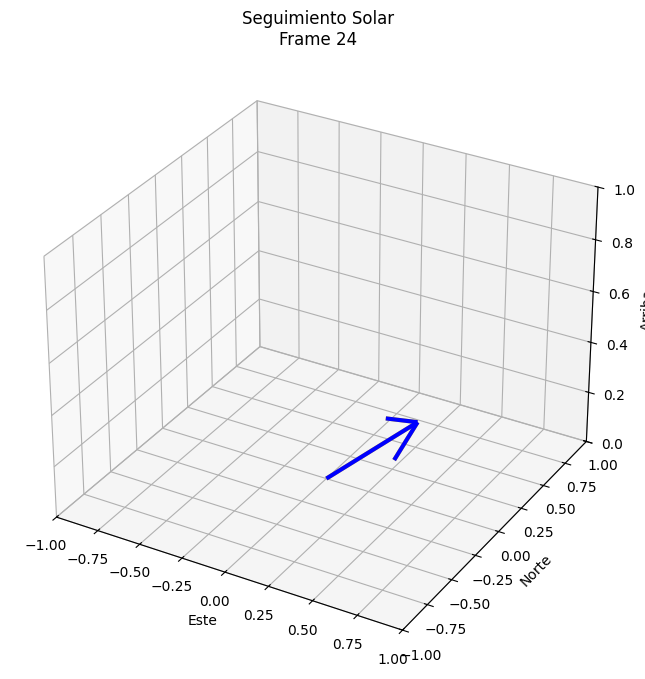

In [9]:
# ===============================
# ANIMACIÓN Y EXPORTACIÓN A GIF
# ===============================
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.set_xlim([-1,1])
ax2.set_ylim([-1,1])
ax2.set_zlim([0,1])
ax2.set_xlabel("Este")
ax2.set_ylabel("Norte")
ax2.set_zlabel("Arriba")

sun_vec2 = None
panel_vec2 = None

def update_anim(i):
    global sun_vec2, panel_vec2

    az = az_hist[i]
    el = el_hist[i]
    phi = phi_hist[i]
    psi = psi_hist[i]

    s = np.array([
        np.cos(el)*np.sin(az),
        np.cos(el)*np.cos(az),
        np.sin(el)
    ])

    n = np.array([
        -np.sin(phi)*np.cos(psi),
        np.sin(psi),
        np.cos(phi)*np.cos(psi)
    ])

    if sun_vec2:
        sun_vec2.remove()
    if panel_vec2:
        panel_vec2.remove()

    sun_vec2 = ax2.quiver(0,0,0, s[0], s[1], s[2], color='gold', linewidth=3)
    panel_vec2 = ax2.quiver(0,0,0, n[0], n[1], n[2], color='blue', linewidth=3)

    ax2.set_title(f"Seguimiento Solar\nFrame {i+1}")
    return sun_vec2, panel_vec2

ani = FuncAnimation(fig2, update_anim, frames=len(az_hist), interval=200)

ani.save("simulacion_seguidor_solar.gif", writer="pillow", fps=10)
print("GIF guardado como: simulacion_seguidor_solar.gif")

plt.show()